# TP1: 

Le but de ce TP1 est d'acquérir les bases nécessaires à la compréhension des réseaux de neurones à partir d'un modèle simple de type Softmax. La tâche d'apprentissage consiste à classifier les images (28 par 28 pixels) de la base MNIST (http://yann.lecun.com/exdb/mnist/) en 10 catégories représentant les chiffres 0-9.

Le TP2 consistera à généraliser les concepts de ce TP1 à un réseau de neurones multi-couches.

## Téléchargement de la base d'entraînement

In [22]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt

if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

## Chargement de la base en mémoire

In [23]:
import dataset_loader
train_set, valid_set, test_set = dataset_loader.load_mnist()

Vous pouvez visualiser les différents caractères en changeant l'identifiant de l'image

label: 1


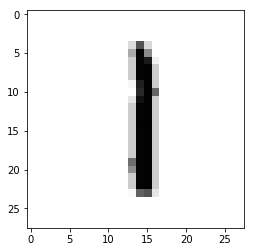

In [24]:
img_id = 900
X=train_set[0][img_id]
plt.imshow(X.reshape(28,28),cmap='Greys')
print("label: " + str(train_set[1][img_id]))

Question 1: Donner les caractéristiques de la base d'apprentissage train_set

In [25]:
def getDimDataset(train_set):
    n_training = len(train_set[0])
    n_feature = len(train_set[0][0])
    n_label = len(set(train_set[1]))
    return n_training, n_feature, n_label

(n_training,n_feature,n_label)=getDimDataset(train_set)
print (n_training,n_feature,n_label)

50000 784 10


## Création du modèle

In [26]:
def init(n_feature,n_label):
    sigma = 1.
    W = np.random.normal(loc=0.0, scale=sigma/np.sqrt(n_feature), size=(n_label,n_feature))
    b = np.zeros((W.shape[0],1))
    return W,b

W,b=init(n_feature,n_label)

Question 2: Donner les dimensions de W et b ainsi que le nombre total de paramètres du modèle

In [27]:
def printInfo(W,b):
    print("W dimensions: " + str(W.shape))
    print("b dimensions: " + str(b.shape))
    print("Number of parameters: " + str(W.shape[0]*W.shape[1]+b.shape[0]))
    
printInfo(W,b)

W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters: 7850


Question 3: Implémenter la fonction forward $$z_j = \sum_{i \rightarrow j} W_{ij} x_i + b_j$$ où $x_i$ est un pixel de l'image, $W_{ij}$ est la valeur associée à l'arête reliant les unités $i$ et $j$ et $b_j$ est le bias associé à l'unité $j$

In [28]:
def forward(W,b,X):
    """
        Perform the forward propagation
        :param W: the weights
        :param b: the bias
        :param X: the input (minibatch_size x n_input)
        :type W: ndarray
        :type B: ndarray
        :type X: ndarray
        :return: the transformed values
        :rtype: ndarray
    """
    #print('forward : X', X.shape, 'W', W.shape, 'b', b.shape)
    z = X.dot(W.transpose()) + b.transpose()
    return z

#X = train_set[0][:5] # 5 examples at once
#print(X.shape)
z = forward(W,b,X) # Works with any number of examples !
#print(z.shape)
#print(z)

Question 4: Implémenter la fonction softmax $$ \sigma_i = P(t=i|x,W,b) = \frac{\exp{z_i}}{\sum_k \exp{z_k}}$$

In [29]:
def softmax(z):
    """
        Perform the softmax transformation to the pre-activation values
        :param z: the pre-activation values
        :type z: ndarray
        :return: the activation values
        :rtype: ndarray
    """
    exps = np.exp(z)
    somme_exps = np.sum(exps,axis=1)
    for i in range(somme_exps.shape[0]):
        exps[i]/=somme_exps[i]
    return exps
out=softmax(z)
print(out.shape)
print (out)

(1, 10)
[[ 0.11098392  0.09631224  0.09733244  0.12459505  0.08784026  0.10749279
   0.08228592  0.09491212  0.09853185  0.09971341]]


Optionnel: Vérifier que votre implémentation de softmax soit numériquement stable (cf. http://ufldl.stanford.edu/wiki/index.php/Exercise:Softmax_Regression)

Question 5: Implémenter le calcul du gradient de l'erreur par rapport à $z_i$:
$$\delta z_i = \sigma_i - 1_{i=l}$$
où $l$ est l'étiquette associée à la donnée courante.

In [30]:
def gradient_out(out, one_hot_batch):
    """
    compute the gradient w.r.t. the pre-activation values of the softmax z_i
    :param out: the softmax values
    :type out: ndarray
    :param one_hot_batch: the one-hot representation of the labels
    :type one_hot_batch: ndarray
    :return: the gradient w.r.t. z
    :rtype: ndarray
    """
    #print('gradient_out : out', out.shape, 'one_hot_batch', one_hot_batch.shape)
    return out - one_hot_batch

derror=gradient_out(out,np.array([0,0,0,0,0,0,0,0,1,0]))
print(derror.shape)
print(derror)

(1, 10)
[[ 0.11098392  0.09631224  0.09733244  0.12459505  0.08784026  0.10749279
   0.08228592  0.09491212 -0.90146815  0.09971341]]


Question 6: Implémenter la fonction du calcul de gradient par rapport aux paramètres: $$\delta W_{ij} = \delta z_j x_i$$  $$\delta b_{j} = \delta z_j$$ où $\delta W_{ij}$ est la composante du gradient associée à l'arête reliant les unités $i$ et $j$, $\delta b_{j}$ est la composante du gradient associée au bias de l'unité $j$, $\delta z_j$ est le gradient de l'erreur par rapport à l'unité $j$ et $x_i$ est la valeur d'activation de l'unité $i$.

In [31]:
def gradient(derror, X):
    """
        Compute the gradient w.r.t. the parameters
        :param derror: the gradient w.r.t. z
        :param X: the input (minibatch_size x n_input)
        :param minibatch_size: the minibatch size
        :type derror: ndarray
        :type minibatch: ndarray
        :type minibatch_size: unsigned
        :return: the gradient w.r.t. the parameters
        :rtype: ndarray, ndarray
    """     
    #grad_w = np.zeros((derror.shape[0],X.shape[0]))
    #grad_b = np.zeros((derror.shape[0]))
    #print(grad_w.shape, grad_b.shape)
    #for j in range(derror.shape[0]):
    #    grad_b[j]=derror[j]
    #    for i in range(X.shape[0]):
    #        grad_w[j][i]=derror[j]*X[i]
    grad_b = derror
    grad_w = derror.transpose().dot(X.reshape(-1, 784))
    #print('gradient_update: grad_w', grad_w.shape, 'grad_b', grad_b.shape)
    return grad_w,grad_b

print(derror.shape, X.shape)
grad_w, grad_b=gradient(derror,X)
print(grad_w.shape, grad_b.shape)
print(grad_w)
print(grad_b)

(1, 10) (784,)
(10, 784) (1, 10)
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[[ 0.11098392  0.09631224  0.09733244  0.12459505  0.08784026  0.10749279
   0.08228592  0.09491212 -0.90146815  0.09971341]]


Question 7: Implémenter la fonction de mise à jour des paramètres $$p = p - \eta \delta p$$ où $p$ est un paramètre du modèle et $\delta p$ la composante du gradient associée à p.

In [32]:
def update(eta, W, b, grad_w, grad_b):
    """
        Update the parameters with an update rule
        :param eta: the step-size
        :param W: the weights
        :param b: the bias
        :param grad_w: the gradient w.r.t. the weights
        :param grad_b: the gradient w.r.t. the bias
        :type eta: float
        :type W: ndarray
        :type b: ndarray
        :type grad_w: ndarray
        :type grad_b: ndarray
        :return: the updated parameters
        :rtype: ndarray, ndarray
    """
    b = b.transpose()
    b = b - eta*grad_b
    W = W - eta*grad_w
    #print('update : W', W.shape, 'b', b.shape, 'grad_w', grad_w.shape, 'grad_b', grad_b.shape)
    return W, b
eta=0.1
W,b=update(eta, W, b, grad_w, grad_b)
print(W.shape, b.shape)
print(b)

(10, 784) (1, 10)
[[-0.01109839 -0.00963122 -0.00973324 -0.0124595  -0.00878403 -0.01074928
  -0.00822859 -0.00949121  0.09014682 -0.00997134]]


Question 8: Implémenter la fonction de calcul du coût et de la précision:
Utiliser les fonction *forward* et *softmax*, puis calculer le coût $c$, qui est moins la log-probabilité des classes à prédire: $$c = - \sum_{(x_{i}, y_{i}) \in \mathcal{D}} \log P(y=y_{i}|x_{i},W,b)$$

Et enfin la précision, c'est à dire le taux de prédictions réussies.

In [33]:
def computeLoss(W, b, batch, labels, softmax):
    """
        Compute the loss value of the current network on the full batch
        :param W: the weights
        :param B: the bias
        :param batch: the weights
        :param labels: the bias
        :param act_func: the weights
        :type W: ndarray
        :type B: ndarray
        :type batch: ndarray
        :type act_func: function
        :return loss: the negative log-likelihood
        :return accuracy: the ratio of examples that are well-classified
        :rtype: float
        :rtype: float
    """ 
    #print('computeLoss: W', W.shape, 'b', b.shape, 'batch', batch.shape, 'labels', labels.shape)
    ### Forward propagation
    z = forward(W,b[:,0:1],batch)
    ### Compute the softmax
    out=softmax(z)
    one_hots = np.zeros_like(out)
    one_hots[:, labels] = 1
    #print(one_hots)
    out[one_hots==0]=1
    loss = -np.sum(np.log(out))
    accuracy = 0
    return loss, accuracy

Question 9: Implémenter la fonction de création de mini-batch, qui pour un indice, une taille de batch, des données d'entraînement et les labels correspondants, renvoie le batch de données/labels correspondant, et la taille du batch. 

In [34]:
def getMiniBatch(i, batch_size, train_set, one_hot):
    """
        Return a minibatch from the training set and the associated labels
        :param i: the identifier of the minibatch
        :param batch_size: the number of training examples
        :param train_set: the training set
        :param one_hot: the one-hot representation of the labels
        :type i: int
        :type batch_size: int
        :type train_set: ndarray
        :type ont_hot: ndarray
        :return: the minibatch of examples
        :return: the minibatch of labels
        :return: the number of examples in the minibatch
        :rtype: ndarray
        :rtype: ndarray
        :rtype: int
    """
    n_training = train_set[0].shape[0]
    idx_begin = i
    idx_end = i+batch_size
    batch = train_set[0][idx_begin:idx_end]
    one_hot=one_hot.transpose()
    one_hot_batch = one_hot[idx_begin:idx_end,:]
    mini_batch_size = batch.shape[0]

    return np.asfortranarray(batch), one_hot_batch, mini_batch_size



## Algorithme d'apprentissage

In [ ]:
import math,time
from IPython.display import clear_output

# Data structures for plotting
g_i = []
g_train_loss=[]
g_train_acc=[]
g_valid_loss=[]
g_valid_acc=[]

n_training, n_feature, n_label = getDimDataset(train_set)

# SGD parameters
eta = 0.001
batch_size = 500
n_batch = int(math.ceil(float(n_training)/batch_size))
n_epoch = 100

cumul_time = 0.

# Initialize the model parameters
W,b = init(n_feature,n_label)
printInfo(W,b)

# Convert the labels to one-hot vector
one_hot = np.zeros((n_label,n_training))
one_hot[train_set[1],np.arange(n_training)]=1.
print('one-hot', one_hot.shape)
print('W', W.shape)
print('b', b.shape)

for i in range(n_epoch):
    for j in range(n_batch):

        ### Mini-batch creation
        minibatch, one_hot_batch, minibatch_size = getMiniBatch(j, batch_size, train_set, one_hot)
        #print('mini batch', minibatch.shape)
        #print('one-hot batch', one_hot_batch.shape)

        prev_time = time.clock()

        ### Forward propagation
        Z = forward(W,b,minibatch)

        ### Compute the softmax
        out = softmax(Z)

        ### Compute the gradient at the top layer
        derror = gradient_out(out,one_hot_batch)

        ### Compute the gradient w.r.t. parameters
        grad_w,grad_b = gradient(derror, minibatch)

        ### Update the parameters
        W,b = update(eta, W, b, grad_w, grad_b)
        b = b.transpose()
        
        curr_time = time.clock()
        cumul_time += curr_time - prev_time
    
    ### Training accuracy
    train_loss, train_acc = computeLoss(W, b, train_set[0], train_set[1],softmax) 
    
    ### Valid accuracy
    valid_loss, valid_acc = computeLoss(W, b, valid_set[0], valid_set[1],softmax) 

    g_i = np.append(g_i, i)
    g_train_loss = np.append(g_train_loss, train_loss)
    g_train_acc = np.append(g_train_acc, train_acc)
    g_valid_loss = np.append(g_valid_loss, valid_loss)
    g_valid_acc = np.append(g_valid_acc, valid_acc)
    
    result_line = str(i) + " " + str(cumul_time) + " " + str(train_loss) + " " + str(train_acc) + " " + str(valid_loss) + " " + str(valid_acc) + " " + str(eta)
    print(result_line)

W dimensions: (10, 784)
b dimensions: (10, 1)
Number of parameters: 7850
one-hot (10, 50000)
W (10, 784)
b (10, 1)
0 1.6679840000000112 2813981.79128 0 567843.834444 0 0.001
1 3.35173300000001 3273275.47737 0 660173.123799 0 0.001
2 4.983918000000003 3580161.82368 0 721916.476342 0 0.001
3 6.58935500000004 3810906.04336 0 768355.054624 0 0.001
4 8.197536999999954 3995327.37283 0 805475.90304 0 0.001
5 9.79683799999998 4148653.68176 0 836342.029043 0 0.001
6 11.393062000000185 4279703.1292 0 862727.355164 0 0.001
7 13.016460000000166 4394037.67716 0 885750.541832 0 0.001
8 14.59985900000035 4495385.37466 0 906161.281684 0 0.001
9 16.222933000000268 4586362.99073 0 924485.760336 0 0.001
10 17.84699300000034 4668875.54197 0 941107.045953 0 0.001
11 19.564967000000422 4744351.64193 0 956312.425416 0 0.001
12 21.20965100000052 4813889.30865 0 970322.722259 0 0.001
13 22.798319000000504 4878350.1309 0 983311.227486 0 0.001
14 24.410527000000457 4938422.24635 0 995416.359146 0 0.001
15 26.092

In [ ]:
plt.plot(g_i,g_train_loss,label='train_loss')
plt.plot(g_i,g_valid_loss,label='valid_loss')
plt.xlabel("epoch")
plt.ylabel("Negative log-likelihood")
plt.legend()

In [ ]:
plt.plot(g_i,1.0-g_train_acc,label='train_acc')
plt.plot(g_i,1.0-g_valid_acc,label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Classification error")
plt.ylim([0.,1.])
plt.legend()

Question 10: Montrer, à l'aide d'une figure, l'effet du step-size (prendre $\eta$=[0.01,0.1,1.0,10.]) sur les courbes d'apprentissage